# Predicting disasters from tweets

$\textbf{Author:}$ Alan Akil

In this project we will take a Kaggle dataset of tweets (text) and build a model to accurately predict if a tweet is reporting a disaster or not.

Link to the Kaggle dataset: https://www.kaggle.com/c/nlp-getting-started/overview

This is a Natural Language Processing (NLP) problem, so modeling is different from numeric datasets. 

Outline of project:

- Load packages and dataset.
- Exploratory Data Analysis.
- Data cleaning / preprocessing. 
- Feature extraction.
- Modeling.
- Assessing performance and choosing the best model.

## Load necessary packages

In [ ]:
import numpy as np
import pandas as pd 
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

In [ ]:
from spellchecker import SpellChecker

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

## Load dataset

Load and explore the dataset.

In [ ]:
df = pd.read_csv("./train.csv")

In [ ]:
df.head()

In [ ]:
df.info()

Print two sample tweets.

In [ ]:
df[df["target"] == 0]["text"].values[1]

In [ ]:
df[df["target"] == 1]["text"].values[1]

## Exploratory Data Analysis

We will plot the distribution of classes to see if they are balanced.

Also, we will look at the distribution of keywords and the distribution of tweet lengths.

Let's first check if classes are balanced by computing the proportion of disaster and non-disaster tweets.

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
df['target'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot of target distribution')
sns.countplot('target', data=df, ax=ax[1])
ax[1].patch.set_alpha(0)
ax[1].set_title('Distribution of target')

plt.show()
#target == 0 : negative(fake)
#target == 1 : postive(real)

Classes are pretty much balanced so we do not need to worry about it.

Let's compute the distribution of keywords in the dataset

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(16,6))
sns.countplot('keyword',data=df,ax=ax,order=df['keyword'].value_counts().index)
ax.set_xlim(0,15)
ax.patch.set_alpha(0)
fig.text(0.13,0.92,"Count distribution by keyword in Tweets", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

Now compute the length of each tweet and then the distribution of tweet lengths.

In [ ]:
def get_length(text):
    return len(text)

df['length'] = df['text'].apply(get_length)
df

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(18,5))
plt.hist(df[df['target'] == 0]['length'], alpha = 0.4, bins=150, label = 'Not', color='red')
plt.hist(df[df['target'] == 1]['length'], alpha = 0.4, bins=150, label = 'Real', color='blue')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
ax.set_ylabel('')
ax.patch.set_alpha(0)
fig.text(0.13,0.8,"Count distribution by length in Tweets", fontweight="bold", fontfamily='serif', fontsize=25)
plt.show()

## Preprocessing

We will see how nan's there are. Note that only the keyword and location columns have nan's and we will get rid of them later on and will not be used in the model, so we don't need to worry about them.

In [ ]:
df.isnull().sum()

Part of the preprocessing is finding stopwords and removing characters that are not parts of relevant words: emojis, punctuation, urls, etc.

In [15]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [16]:
def preprocess(text,stem=False):
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & with and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URL
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    text = re.sub('(@[A-Za-z]+[A-za-z0-9-_]+)', '', text) # remove @username
    text = re.sub('rt', '', text) # remove rt
#     Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(SnowballStemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [17]:
spell = SpellChecker()
def correct_spell(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

Apply all preprocessing at once.

In [18]:
df.text = df.text.apply(lambda x: preprocess(x))
# df.text = df.text.apply(lambda x: correct_spell(x)) # This takes time!

Get rid of columns that will not be used for training.

In [19]:
df.drop(['keyword','id','location','length'],axis=1,inplace=True)
df.head()

,text,target
0,deeds reason #eahquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,13000 people receive #wildfires evacuation ord...,1
4,got sent photo ruby #alaska smoke #wildfires p...,1


## Feature extraction

We will start with simpler models and move towards more complex. The first models to test are logistic regression, random forests and XGBoost. 

Before we do this, we first transform the text into a suitable numeric input by using the TF-IDF algorithm. This algorithm tokenizes each tweet and then keeps the most relevant features (Ngrams) based on the TF*IDF measure.  

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfIdf = TfidfVectorizer(max_features=3000) 
df_after_tfidf = TfIdf.fit_transform(df['text'])

## Modeling

Let's start our modeling with Logistic Regression, Random Forests, and XGBoosting.

Before that, split our new dataframe into 80% train and 20% test.

In [21]:
from sklearn.metrics import accuracy_score # метрика качества
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(df_after_tfidf,df.target,test_size = 0.2, random_state = 123) 

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

models = [ LogisticRegression(),
          RandomForestClassifier(),
          XGBClassifier() ]

best_model = ''
best_score = 0
i = 0
for model in models:
    model.fit(X_train, y_train)
    predicted_score = model.predict(X_test)
    
    val_score = accuracy_score(y_test, predicted_score)
    
    if val_score > best_score:
        best_score = val_score
        best_model = model
        
    if i == 0:
        logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
        fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        print(f'The {model} has auc = {logit_roc_auc}')
    elif i == 1:
        rf_roc_auc = roc_auc_score(y_test, model.predict(X_test))
        fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        print(f'The {model} has auc = {rf_roc_auc}')
    elif i == 2:
        xgb_roc_auc = roc_auc_score(y_test, model.predict(X_test))
        fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        print(f'The {model} has auc = {xgb_roc_auc}')
        
    print(f'The {model} has val_acc = {val_score}')
    i+=1
    
print(f'\n The best model is {best_model} and has validation accuracy of {best_score}')

The LogisticRegression() has auc = 0.7868457592266763
The LogisticRegression() has val_acc = 0.8049901510177282
The RandomForestClassifier() has auc = 0.7679666687865234
The RandomForestClassifier() has val_acc = 0.7846355876559422
[15:59:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/bmnn/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


The XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) has auc = 0.7528379581540288
The XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimator

$\textbf{Note:}$ As it is seen above, the best model so far is actually logistic regression -- it has better accuracy and auc score than RF's and XGBoost.

## Modeling LSTM network

We will now train an LSTM RNN on this dataset so we will tokenize and build into sequences our data.

Then we will add an input layer to the LSTM model that applies the GloVe model. GloVe stands for Global Vectors and gives vector representations of words in 'high' dimensional space where similar words and near in distance.

In [23]:
train_data, test_data = train_test_split(df,test_size = 0.2)
print("Train Data size : ",len(train_data))
print("Test Data size : ",len(test_data))

Train Data size :  6090
Test Data size :  1523


In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size : ",vocab_size)

Vocab size :  15756


In [25]:
max_dim = 100 # Pick a maximum dimension for the sequences of words in a tweet.

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = max_dim)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = max_dim)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (6090, 100)
Testing X Shape: (1523, 100)


In [26]:
y_train = train_data.target
y_test = test_data.target

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (6090,)
y_test shape: (1523,)


Let's load the GloVe model and include it in our Keras model as the first layer.

In [56]:
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 512

GLOVE_EMB = '/Users/alan/Downloads/glove/glove.6B.300d.txt'

In [57]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400001 word vectors.


In [58]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [59]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=max_dim,
                                           trainable=False)

Define the LSTM network model.

In [60]:
inputs = Input(shape=(max_dim,),dtype = 'int32')

embedding = embedding_layer(inputs)
net = SpatialDropout1D(0.2)(embedding)
net = Bidirectional(LSTM(64,dropout=0.2, recurrent_dropout=0.2))(net)
net = Dense(1,activation = 'sigmoid')(net)

outputs = net
lstm_model = tf.keras.Model(inputs,outputs)

Compile the LSTM model with an optimizer, loss metric, and performance metric.

In [61]:
lstm_model.compile(optimizer = Adam(learning_rate = LR),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [62]:
callback = ReduceLROnPlateau(factor=0.1,
                    min_lr = 0.005,
                    monitor = 'val_loss',
                    verbose = 1)

Fit the model. Note that the pretrained layer is frozen.

In [63]:
history = lstm_model.fit(x_train,
                    y_train,
                    batch_size=512,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    callbacks = [callback])

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 17s 3ms/sample - loss: 0.6451 - accuracy: 0.6596 - val_loss: 0.5629 - val_accuracy: 0.7663
Epoch 2/10
6090/6090 [==============================] - 14s 2ms/sample - loss: 0.5368 - accuracy: 0.7654 - val_loss: 0.4860 - val_accuracy: 0.7741
Epoch 3/10
6090/6090 [==============================] - 14s 2ms/sample - loss: 0.4838 - accuracy: 0.7831 - val_loss: 0.4751 - val_accuracy: 0.7853
Epoch 4/10
6090/6090 [==============================] - 14s 2ms/sample - loss: 0.4618 - accuracy: 0.7893 - val_loss: 0.4545 - val_accuracy: 0.7945
Epoch 5/10
6090/6090 [==============================] - 13s 2ms/sample - loss: 0.4480 - accuracy: 0.7993 - val_loss: 0.4432 - val_accuracy: 0.8083
Epoch 6/10
6090/6090 [==============================] - 13s 2ms/sample - loss: 0.4425 - accuracy: 0.8039 - val_loss: 0.4401 - val_accuracy: 0.8076
Epoch 7/10
6090/6090 [==============================] - 13s 2ms/sample

Plot accuracy and loss of training and testing.

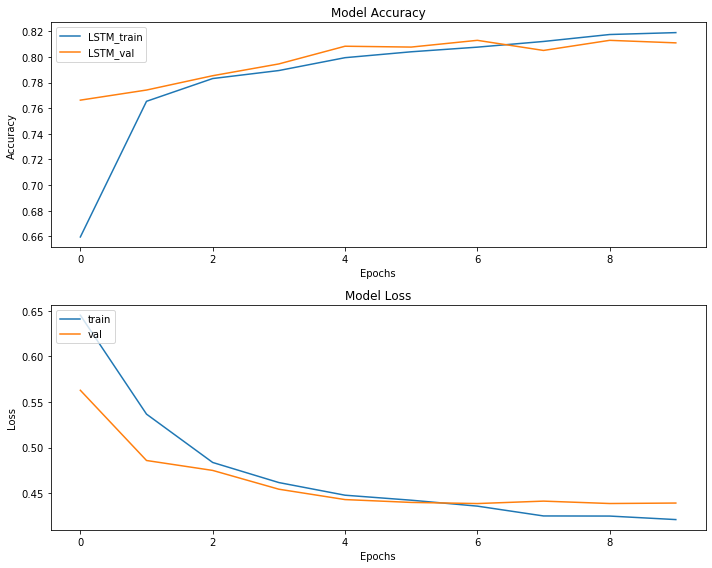

In [64]:
f,ax = plt.subplots(2,1,figsize=(10,8))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

## Fine tuning LSTM pretrained layer

We have trained our LSTM network with a frozen pretrained layer. We will now fine tune it by unfreezing the pretrained layer with a low learning rate in order to get higher performance.

In [70]:
embedding_layer.trainable = True # Unfreeze pretrained layer.

# Recompile model with lower learning rate.
lstm_model.compile(optimizer = Adam(learning_rate = 1e-4),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

# Train.
history_fine_tune = lstm_model.fit(x_train,
                    y_train,
                    batch_size=512,
                    epochs=50,
                    validation_data=(x_test, y_test),
                    callbacks = [callback])

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 18s 3ms/sample - loss: 0.4087 - accuracy: 0.8235 - val_loss: 0.4397 - val_accuracy: 0.8109
Epoch 2/10
6090/6090 [==============================] - 15s 2ms/sample - loss: 0.4053 - accuracy: 0.8271 - val_loss: 0.4351 - val_accuracy: 0.8175
Epoch 3/10
6090/6090 [==============================] - 15s 3ms/sample - loss: 0.4037 - accuracy: 0.8241 - val_loss: 0.4374 - val_accuracy: 0.8142
Epoch 4/10
6090/6090 [==============================] - 15s 2ms/sample - loss: 0.3994 - accuracy: 0.8276 - val_loss: 0.4375 - val_accuracy: 0.8148
Epoch 5/10
6090/6090 [==============================] - 16s 3ms/sample - loss: 0.3945 - accuracy: 0.8332 - val_loss: 0.4369 - val_accuracy: 0.8155
Epoch 6/10
6090/6090 [==============================] - 18s 3ms/sample - loss: 0.3936 - accuracy: 0.8342 - val_loss: 0.4373 - val_accuracy: 0.8155
Epoch 7/10
6090/6090 [==============================] - 18s 3ms/sample

Plot accuracy and loss of training and testing during fine tuning.

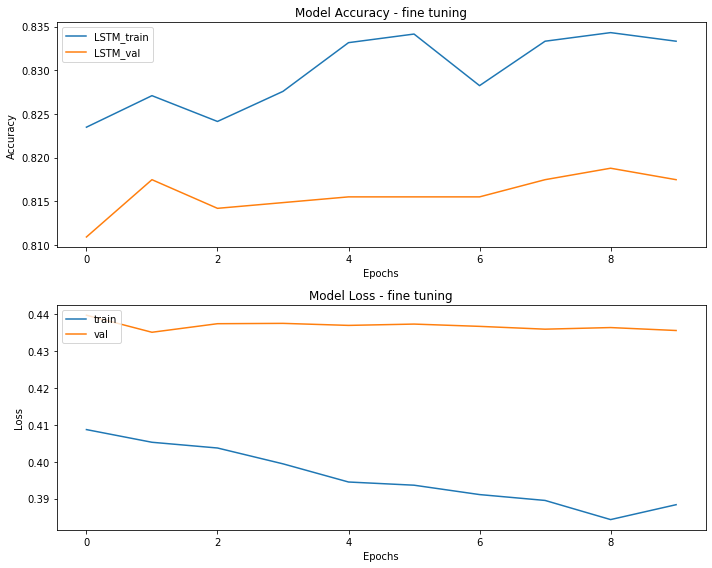

In [75]:
f,ax = plt.subplots(2,1,figsize=(10,8))

ax[0].plot(history_fine_tune.history['accuracy'])
ax[0].plot(history_fine_tune.history['val_accuracy'])
ax[0].set_title('Model Accuracy - fine tuning')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')


ax[1].plot(history_fine_tune.history['loss'])
ax[1].plot(history_fine_tune.history['val_loss'])
ax[1].set_title('Model Loss - fine tuning')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

Let's look at the confusion matrix for the LSTM model which will be the best one.

In [72]:
y_pred = lstm_model.predict(x_test)>0.5
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix = ")
print(confusionMatrix)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Confusion Matrix = 
[[768 113]
 [165 477]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       881
           1       0.81      0.74      0.77       642

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



## Assess performance of all models

Compute ROC curves for all models.

In [73]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_lstm = lstm_model.predict(x_test).ravel()
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_pred_lstm)
auc_keras = auc(fpr_lstm, tpr_lstm)

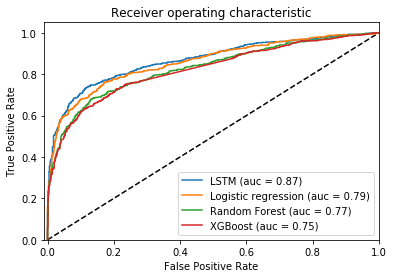

In [74]:
plt.figure()

plt.plot(fpr_lstm, tpr_lstm, label='LSTM (auc = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.plot(fpr_logit, tpr_logit, label='Logistic regression (auc = %0.2f)' % logit_roc_auc)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (auc = %0.2f)' % rf_roc_auc)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (auc = %0.2f)' % xgb_roc_auc)

plt.legend(loc="lower right")
plt.show()

## Conclusion

We successfully classified tweets into texts that refered to disasters and text that did not. We went through nearly all steps in the modeling process starting with loading and exploring the dataset, cleaning and preprocessing the data, feature extraction, and finishing with model fitting and performance assessment. 

As is always good practice, we started off with simpler models and moved towards more complex ones seeking higher performance.

Initially we fit the data to a Logistic Regression model (auc=0.79). After that we moved to ensemble models: Random forests and XGBoost which actually performed worse than logistic regression, auc=0.77 and auc=0.75, respectively.

Finally, we fit the data to a recurrent neural network (LSTM), where we obtained the best performance with an auc score of 0.87!